In [1]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from pmoe.datasets import build_unipolynomial_dataset, build_trte_dataloader
from pmoe.bayes_models import BayesLinearRegression
from pmoe.moe_models import MoELinearRegression
%matplotlib inline

In [2]:
torch.manual_seed(0)
np.random.seed(10)

In [3]:
def frequentist_risk(model, x: np.ndarray, 
                     y: np.ndarray, 
                     coeff: np.ndarray, 
                     std_dev: float, 
                     samples=1000, 
                     torch_model=False) -> float:
    criterion = lambda y, y_hat: (y - y_hat)**2
    # Calculate the means
    means = np.polyval(coeff, x[:,0])
    
    # Calculate log densities
    log_density = (- math.log(std_dev) 
                 - math.log(math.sqrt(2*math.pi))
                 - (((y - means)**2) / (2 * (std_dev**2)))
    )
    log_density = np.expand_dims(log_density, axis=1)

    # Renormalize
    density = np.exp(log_density)
    probs = density / np.sum(density)

    # Make the prediction here
    y = np.expand_dims(y, axis=1)    

    if torch_model:
        device = torch.device('cpu')
        model = model.to(device)
        model.eval()
        x = torch.Tensor(x).to(device)

        # Take a Monte Carlo average
        y_preds = np.zeros_like(y)
        for _ in range(samples):
            y_hat_i = model.predict(x).detach().to(device).numpy()
            y_preds += y_hat_i
        
        y_hat = y_preds / samples
    else:
        # Take a Monte Carlo average to approximate posterior mean
        y_preds = np.zeros_like(y)
        for _ in range(samples):
            y_hat_i = model.predict(x)
            y_hat_i = np.expand_dims(y_hat_i, axis=1)
            y_preds += y_hat_i
        
        y_hat = y_preds / samples

    # Record the loss
    loss = criterion(y, y_hat)
    risk = loss * probs
    risk = np.sum(risk)
        
    return risk

We build the degrees of unipolynomials here.  Each dataset will be a polynomial of a certain degrees `[1,2,3,4,5,6,7]`.  We will test various models up to a MoE with 3 experts to see how well the various models do at the mean squared error. 

In [4]:
degrees = [1, 2, 3, 4, 5]
coefficients = [2,3,-1,-1,1,1]
likelihood_std = 0.1
LR = [0.2 for _ in degrees]
EPOCHS = [30 for d in degrees]
tr_datasets = {}
te_datasets = {}
dataloaders = {}
coefficient_dict = {}
for d in degrees:
    # Build and store the train data
    data, coeff = build_unipolynomial_dataset(-2.0, 
                                       1.0, 
                                       d, 
                                       12000, 
                                       std_dev=likelihood_std, 
                                       rescale=True, 
                                       coefficients=coefficients)

    # Build the data sets
    tr_data, te_data = data[:-2000], data[-2000:]
    tr_datasets[d] = tr_data
    te_datasets[d] = te_data
    tr_load, te_load = build_trte_dataloader(tr_data)
    dataloaders[d] = (tr_load, te_load)
    
    # Recover the scaled coefficients
    p = np.polynomial.Polynomial.fit(data[:,0].flatten(), data[:,-1].flatten(), deg=d)
    coefficient_dict[d] = p.convert().coef[::-1]

To make sure our data was properly generated, we plot some of the datasets.

(10000, 1)
(10000,)


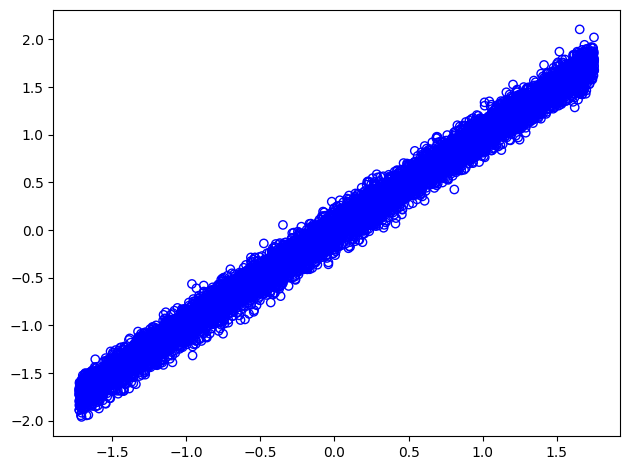

In [5]:
# Plot the 1 degree polynomial
fig = plt.figure()
x, y = tr_datasets[1][:,:-2], tr_datasets[1][:,-1]
print(x.shape)
print(y.shape)
plt.scatter(x, y, facecolors='none', edgecolors='b')
fig.tight_layout()
plt.show()

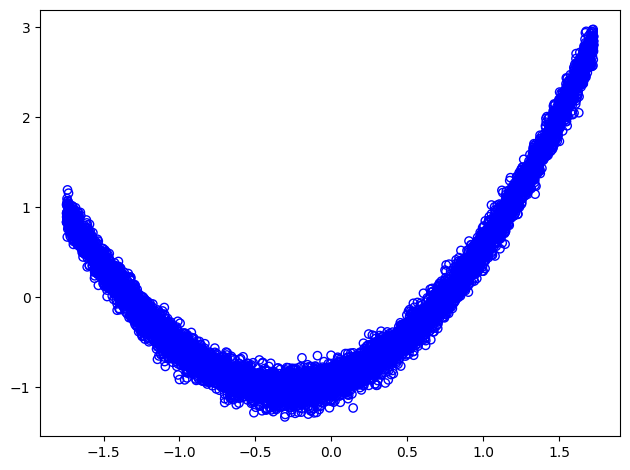

In [6]:
# Plot the 2 degree polynomial
fig = plt.figure()
x, y = tr_datasets[2][:,:-2], tr_datasets[2][:,-1]
plt.scatter(x, y, facecolors='none', edgecolors='b')
fig.tight_layout()
plt.show()

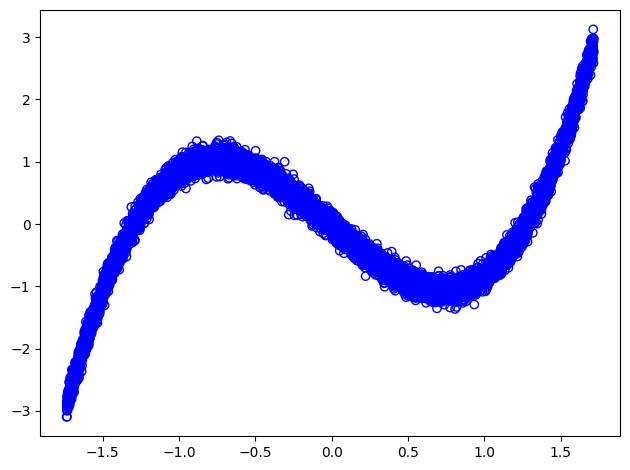

In [7]:
# Plot the 3 degree polynomial
fig = plt.figure()
x, y = tr_datasets[3][:,:-2], tr_datasets[3][:,-1]
plt.scatter(x, y, facecolors='none', edgecolors='b')
fig.tight_layout()
plt.show()

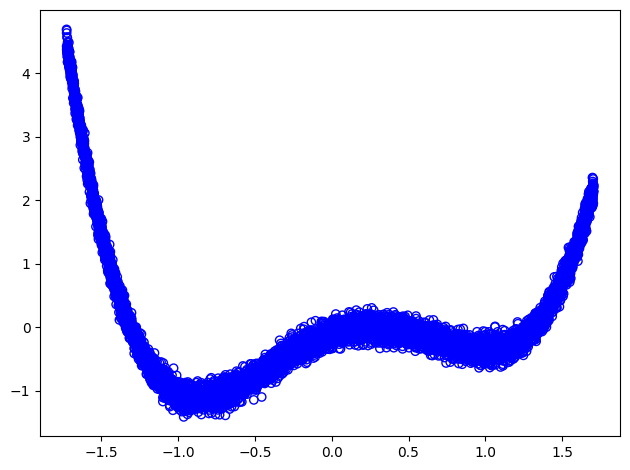

In [8]:
# Plot the 4 degree polynomial
fig = plt.figure()
x, y = tr_datasets[4][:,:-2], tr_datasets[4][:,-1]
plt.scatter(x, y, facecolors='none', edgecolors='b')
fig.tight_layout()
plt.show()

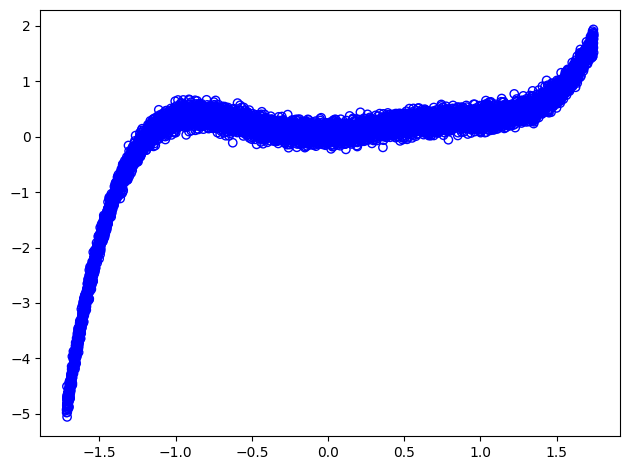

In [9]:
# Plot the 5 degree polynomial
fig = plt.figure()
x, y = tr_datasets[5][:,:-2], tr_datasets[5][:,-1]
plt.scatter(x, y, facecolors='none', edgecolors='b')
fig.tight_layout()
plt.show()

We build the various models.

In [10]:
max_experts = 4
moe_models = [i for i in range(2, max_experts+1)]

First run the linear model through the datasets and record its mean squared error.

In [11]:
linear_mse = []
linear_risk = []
for d in degrees:
    data = tr_datasets[d]
    X, Y = data[:,:-1], data[:,-1]
    linear_model = BayesLinearRegression(2, likelihood_std)
    linear_model.fit(X=X, Y=Y)

    # Calculate the MSE
    test_data = te_datasets[d]
    x, y = test_data[:,:-1], test_data[:,-1]
    y_hat = linear_model.predict(x)
    error = mean_squared_error(y, y_hat)
    print(f'The error on degree {d} is {error}.')
    linear_mse.append(error)

    # Calculate the frequentist risk
    coeff = coefficient_dict[d]
    risk = frequentist_risk(linear_model, x, y, coeff, likelihood_std, torch_model=False)
    print(f'The frequentist risk on degree {d} is {risk}.')
    linear_risk.append(risk)

The error on degree 1 is 0.018942769526467992.
The frequentist risk on degree 1 is 0.005028226085364608.
The error on degree 2 is 0.7048039072382494.
The frequentist risk on degree 2 is 0.6888073510128363.
The error on degree 3 is 1.0041227504241974.
The frequentist risk on degree 3 is 0.9898297739944224.
The error on degree 4 is 0.9181496789821033.
The frequentist risk on degree 4 is 0.9321428150232831.
The error on degree 5 is 0.6211650884941119.
The frequentist risk on degree 5 is 0.6071076154774215.


Now we loop through the various mixture of experts.

In [12]:
expert_mse = np.zeros((len(degrees), len(moe_models)))
expert_risk = np.zeros((len(degrees), len(moe_models)))
stored_models = {}
for i, d in enumerate(degrees):
    # Build the data
    tr_load, te_load = dataloaders[d]
    test_data = te_datasets[d]
    x, y = test_data[:,:-1], test_data[:,-1]
    x_t = torch.Tensor(x).to(torch.device('mps'))

    # Train the models and collect the test results
    print(f'Training and testing MoE models on degree {d}.')
    print('---------------------')
    models = []
    for j, n in enumerate(moe_models):
        print(f'Training MoE with {n} experts on degree {d}.')
        model = MoELinearRegression(n, 2, top_k=2)
        model.fit(tr_load, te_load, EPOCHS[i], LR[i])

        # Calculate MSE
        y_hat = model.predict(x_t).detach().to(torch.device('cpu')).numpy()
        error = mean_squared_error(y, y_hat)
        print(f'The MSE on the hold out test set was {error}.')

        # Calculate risk
        coeff = coefficient_dict[d]
        risk = frequentist_risk(model, x, y, coeff, likelihood_std, torch_model=True)
        print(f'The frequentist risk on degree {d} is {risk}.')

        # Save the results
        expert_mse[i,j] = error
        expert_risk[i,j] = risk
        # Save the model
        models.append(model)
    
    # Store in dictionary
    stored_models[d] = models

Training and testing MoE models on degree 1.
---------------------
Training MoE with 2 experts on degree 1.
Using device: mps
Metrics for epoch 0 are:
 tr_loss: 0.040055905133485795, te_loss: 0.011673984830849804, current_lr: 0.15000000000000002.
Metrics for epoch 10 are:
 tr_loss: 0.01010392228513956, te_loss: 0.01040332044067327, current_lr: 0.008447027206420899.
Metrics for epoch 20 are:
 tr_loss: 0.010038281831890344, te_loss: 0.010069796975585632, current_lr: 0.000475681790840099.
The MSE on the hold out test set was 0.019856687469945775.
The frequentist risk on degree 1 is 0.0050476490055025545.
Training MoE with 3 experts on degree 1.
Using device: mps
Metrics for epoch 0 are:
 tr_loss: 0.02208379343897104, te_loss: 0.01077296472794842, current_lr: 0.15000000000000002.
Metrics for epoch 10 are:
 tr_loss: 0.01009740000590682, te_loss: 0.010526304075028747, current_lr: 0.008447027206420899.
Metrics for epoch 20 are:
 tr_loss: 0.01002883955463767, te_loss: 0.010120859515154734, cur

Graph the logarithmic mean squared error.

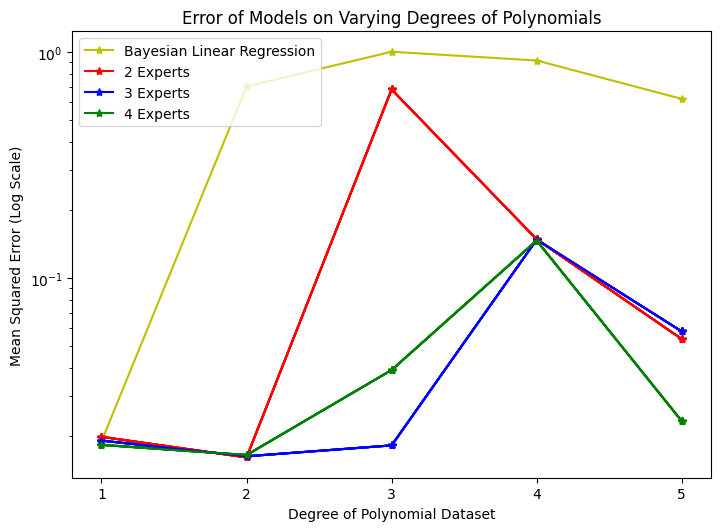

In [19]:
fig, axs = plt.subplots(1,1, figsize=(7,5))
colors = ['r*-', 'b*-', 'g*-']

axs.plot(degrees, linear_mse, 'y*-')

# Graph the results
for i, d in enumerate(degrees):
    for j in range(len(moe_models)):
        y = expert_mse[:,j]
        axs.plot(degrees, y, colors[j])

fig.tight_layout()
axs.set_xticks(degrees)
axs.set_yscale('log')
axs.set_xlabel('Degree of Polynomial Dataset')
axs.set_ylabel('Mean Squared Error (Log Scale)')
axs.set_title('Error of Models on Varying Degrees of Polynomials')
axs.legend(['Bayesian Linear Regression', '2 Experts', '3 Experts', '4 Experts'])

plt.show()

Graph the frequentist risk.

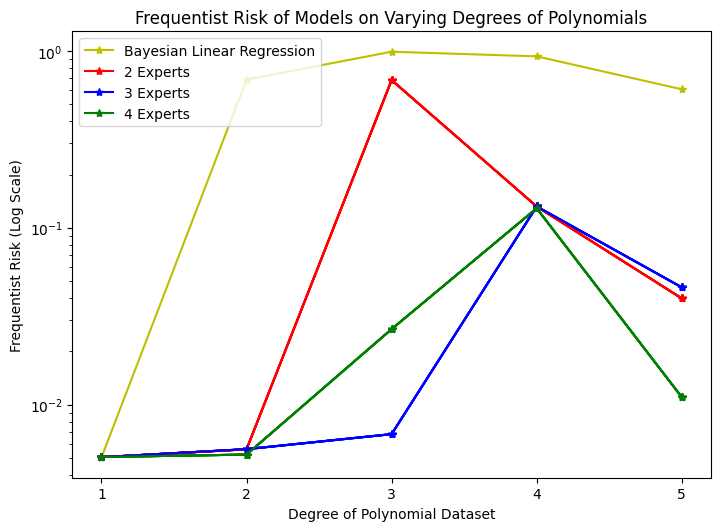

In [14]:
fig, axs = plt.subplots(1,1, figsize=(7,5))
colors = ['r*-', 'b*-', 'g*-']

axs.plot(degrees, linear_risk, 'y*-')

# Graph the results
for i, d in enumerate(degrees):
    for j in range(len(moe_models)):
        y = expert_risk[:,j]
        axs.plot(degrees, y, colors[j])

fig.tight_layout()
axs.set_xticks(degrees)
axs.set_yscale('log')
axs.set_xlabel('Degree of Polynomial Dataset')
axs.set_ylabel('Frequentist Risk (Log Scale)')
axs.set_title('Frequentist Risk of Models on Varying Degrees of Polynomials')
axs.legend(['Bayesian Linear Regression', '2 Experts', '3 Experts', '4 Experts'])
axs.margins(0,0.5)
plt.show()